# Examples of model output

This notebook demonstrates some examples of how to visualize the model outputs

The main 2d output files are: 
- ds_soil: variables calculated in the soil 
    - theta
- ds_root: variables calculated in the root 
    - Kr_sink
    - S_kr
    - S_sink
    - EVsink_ts : Sink term for soil 
- ds_canopy: variables calculated in the canopy
    - S_kx
    - trans_2d
- ds_all: variables calculated over the entire z domain 
    - H
    - K 
    - Capac 

In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fetch3.helpers import load_model_outputs

from pathlib import Path
%matplotlib widget

In [2]:
def get_canopy_H(dsall, dscanopy):
    H = dsall.H
    zind_canopy = np.arange(len(dsall.z) - len(dscanopy.z),len(dsall.z))
    H_can = H.isel(z=zind_canopy)
    return zind_canopy, H_can

In [3]:
# CHANGE TO THE CORRECT FILE PATH FOR YOUR OUTPUT
# Directory where the model outputs were written
model_output_dir = "/Users/jmissik/Desktop/repos/fetch3_nhl/output/UMBS_test_Ameriflux_M8_20220512T144509/000000"

In [4]:
# CHANGE TO THE CORRECT FILE PATH FOR YOUR COMPUTER
# loading the input met data

filein = "/Users/jmissik/Desktop/repos/fetch3_nhl/data/UMBS_flux_2011.csv"
met = pd.read_csv(filein, parse_dates=['Timestamp'])
met = met.set_index('Timestamp')

## Loading the data

There is a convenience function in fetch3.helpers to load a set of the model outputs at once: 

In [5]:
dsall, canopy, soil, roots, sapflux, nhl = load_model_outputs(model_output_dir)

Alternatively, you can load a model output file yourself, for example: 

In [6]:
# filein can be a pathlib Path, or simply a string of the file path
filein = Path(model_output_dir) / "sapflux.nc"
sapflux = xr.load_dataset(filein)

The netcdf output files are loaded as xarray dataset objects. You can easily view the varibles in the dataset, 
coordinates (in this case, z and time), and metadata:

In [7]:
sapflux

<xarray.Dataset>
Dimensions:  (time: 98)
Coordinates:
  * time     (time) datetime64[ns] 2011-07-06 ... 2011-07-08T00:30:00
Data variables:
    sapflux  (time) float64 nan -8.798e-09 -3.095e-09 ... 2.299e-09 1.352e-09
    storage  (time) float64 0.05478 0.05476 0.05475 ... 0.05474 0.05474 0.05474
    delta_S  (time) float64 nan -1.055e-08 -4.845e-09 ... 5.49e-10 1.352e-09

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
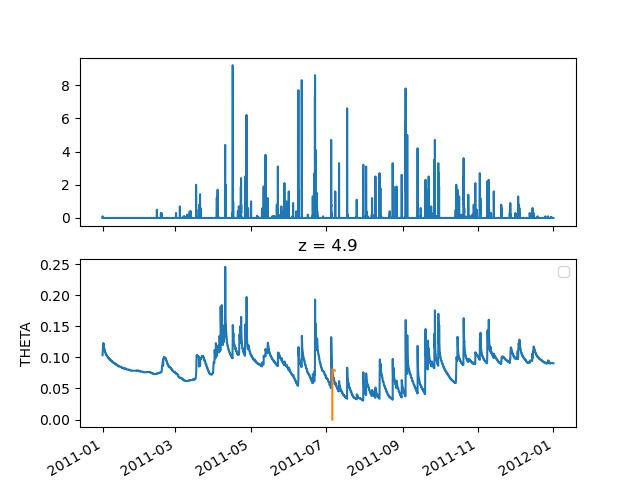

In [8]:
fig, axs = plt.subplots(2,1, sharex = True)

ax = axs[0]
ax.plot(met.P_F)

ax = axs[1]
ax.plot(met.SWC_m3m3)

# plot model SWC
soil.THETA.sel(z=4.9).plot(x='time')

# #select just range of model 
# ax.set_xlim(soil.time.min(), soil.time.max())
# ax.legend(['obs SWC', 'model SWC'])

plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
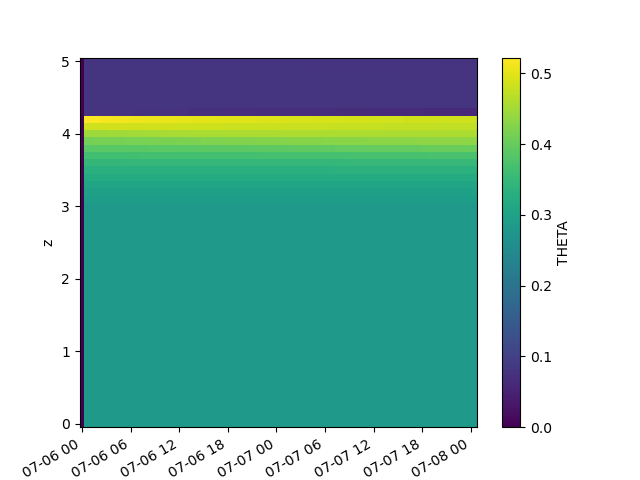

In [9]:
fig, axs = plt.subplots()

ax = axs

soil.THETA.plot(x='time')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
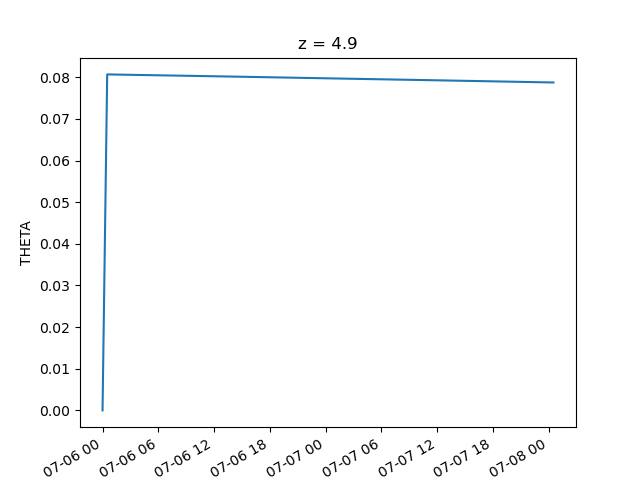

In [10]:
# Plot soil moisture at one depth (z=4.9)
fig, axs = plt.subplots()

ax = axs

soil.THETA.sel(z=4.9).plot(x='time')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
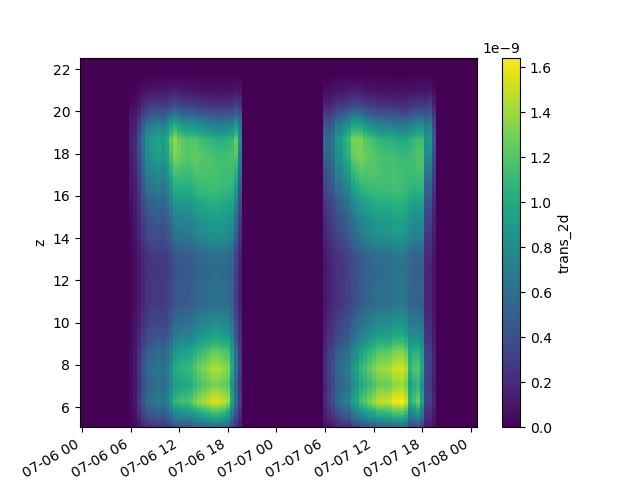

In [12]:
# Transpiration
fig, axs = plt.subplots()

ax = axs

canopy.trans_2d.plot(x='time')

In [13]:
# Calculate vertically integrated transpiration
dz = canopy.z[1] - canopy.z[0]
trans_tot = (canopy.trans_2d * dz).sum(dim='z')

In [14]:
#NHL transpiration (transpiration before reduction from xylem water potential was applied)
filein = Path(model_output_dir) / 'nhl_out.nc'
nhl2 = xr.load_dataset(filein)
nhl_tot = (nhl2.NHL_trans_sp_stem * dz).sum(dim='z')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
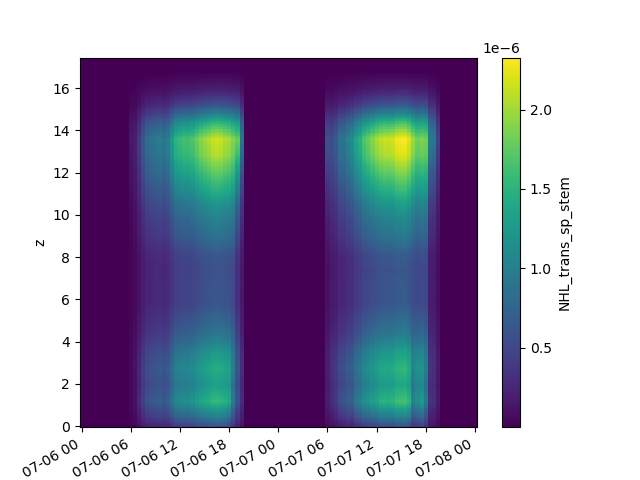

In [15]:
fig, axs = plt.subplots()

ax = axs

nhl2.NHL_trans_sp_stem.plot(x='time')

In [16]:
nfilein = Path(model_output_dir) / 'nhl_modelres_trans_out.nc'
nhl3 = xr.load_dataset(filein)
nhl_tot = (nhl3.NHL_trans_sp_stem * dz).sum(dim='z')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
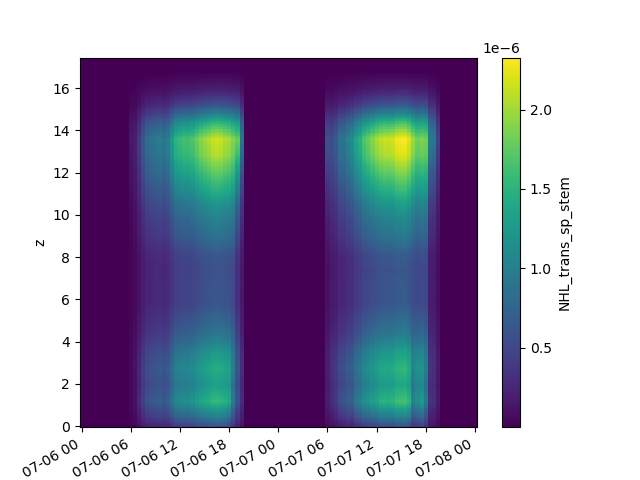

In [17]:
fig, axs = plt.subplots()

ax = axs

nhl3.NHL_trans_sp_stem.plot(x='time')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
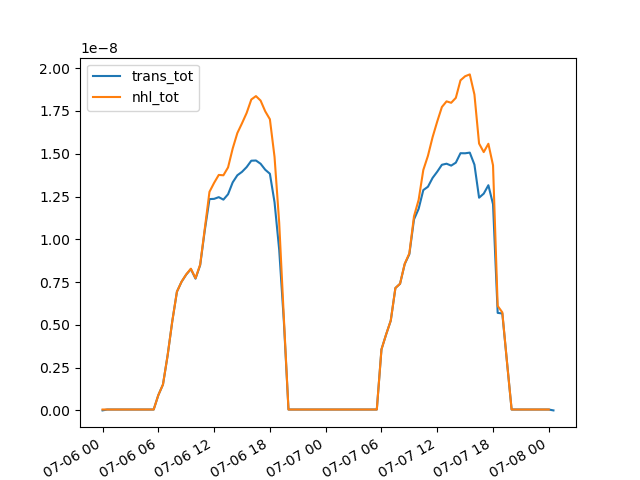

In [19]:
#Plot NHL transpiration and model transpiration

fig, axs = plt.subplots()

ax = axs

trans_tot.plot.line(x='time')
(nhl_tot*(10**-3)).plot.line(x='time')
ax.legend(["trans_tot", "nhl_tot"])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
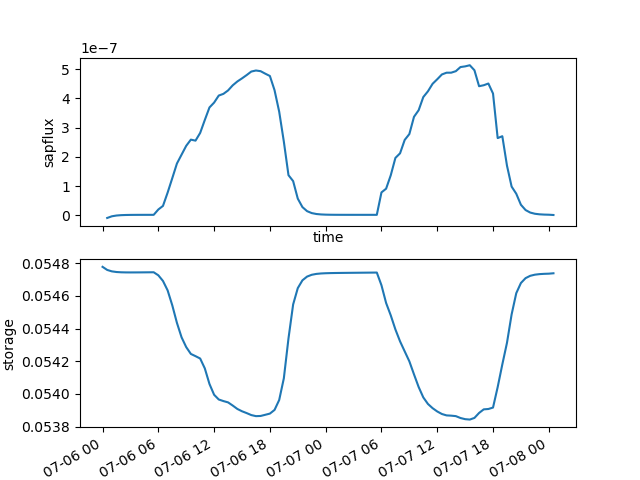

In [25]:
# Plot sapflux and change in storage
fig, axs = plt.subplots(2,1, sharex = True)

ax = axs[0]
sapflux.sapflux.plot.line(x='time', ax=ax)

ax = axs[1]
sapflux.storage.plot.line(x='time', ax=ax)
# ax.legend(["sapflux", "delta S", "storage"])